<a href="https://colab.research.google.com/github/jaspergass/Tomato-Object-Detection/blob/Jasper-Branch/Tomato_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

In [3]:
#set the paths to labels and images directory
label_dir= "/content/drive/MyDrive/SFU_Archive/IAT360/Computer Vision Project/Datasets/Tomato.v1i.yolov8/labels"
image_dir="/content/drive/MyDrive/SFU_Archive/IAT360/Computer Vision Project/Datasets/Tomato.v1i.yolov8/images"

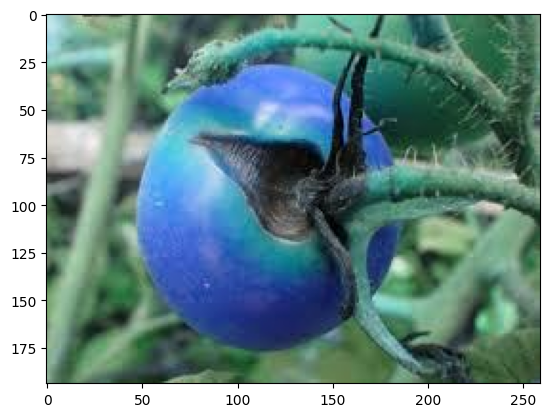

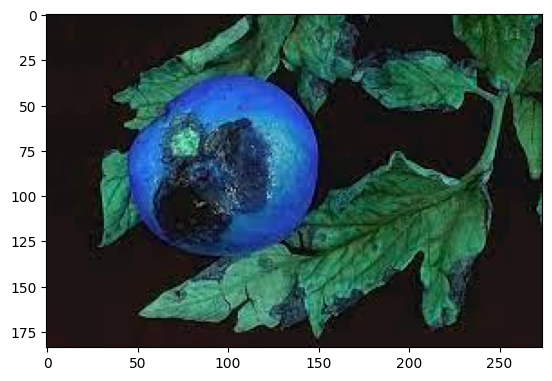

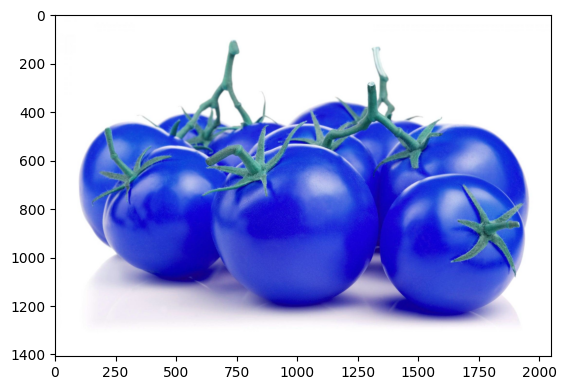

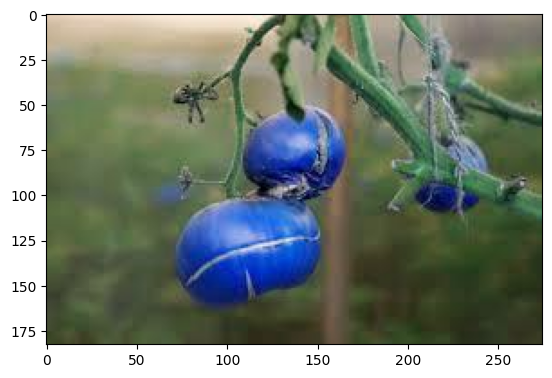

In [4]:
#visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir,"train", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

In [ ]:
def seg_to_bbox(seg_info):
    # Example input: 2 0.207031 0.558594 0.208984 0.527344 0.210938 0.488281 0.214844 0.445312 0.21875 0.412109 0.222656 0.382812
    class_id, *points = seg_info.split()
    points = [float(p) for p in points]
    x_min, y_min, x_max, y_max = min(points[0::2]), min(points[1::2]), max(points[0::2]), max(points[1::2])
    bbox_info = f"{class_id} {x_min} {y_min} {x_max} {y_max}"
    return bbox_info

In [ ]:
seg_info = "0 0.6496444731738853 0.017921146953405017 0.5597931480284422 0.2810035842293907 0.6095669036845508 0.28888888888888886 0.6574014221073045 0.3032258064516129 0.7000646412411118 0.3326164874551971 0.7459599224305107 0.385663082437276 0.7608274078862314 0.4121863799283154 0.7776341305753071 0.45161290322580644 0.7873303167420814 0.4774193548387097 0.7957336780866192 0.5118279569892473 0.8009049773755657 0.556989247311828 0.8015513897866839 0.592831541218638 0.7970265029088559 0.6379928315412187 0.7899159663865546 0.6745519713261648 0.7692307692307693 0.7318996415770609 0.7420814479638009 0.7784946236559139 0.7058823529411765 0.8193548387096774 0.6535229476405947 0.8580645161290322 0.5740142210730446 0.8924731182795699 0.5313510019392372 0.9046594982078853 0.4906270200387847 0.9046594982078853 0.40917905623787976 0.8982078853046594 0.3826761473820297 0.8931899641577061 0.3477698771816419 0.8810035842293907 0.32255979314802846 0.8688172043010752 0.27472527472527475 0.8308243727598567 0.23529411764705882 0.7784946236559139 0.21008403361344538 0.7326164874551971 0.19457013574660634 0.6896057347670251 0.18034906270200388 0.614336917562724 0.18164188752424046 0.5519713261648745 0.18939883645765998 0.5146953405017921 0.1997414350355527 0.4774193548387097 0.22107304460245636 0.43082437275985663 0.2559793148028442 0.37992831541218636 0.28183581124757595 0.35555555555555557 0.3251454427925016 0.32974910394265233 0.10019392372333563 0.13261648745519714 0.46218487394958013 0.053763440860215055"
bbox_info = seg_to_bbox(seg_info)
print(bbox_info)  # Output: "2 0.207031 0.382812 0.21875 0.558594"

-1 0.10019392372333563 0.017921146953405017 0.8015513897866839 0.9046594982078853


In [ ]:
#me trying to apply the scale before using the segment to box function.
seg_info = "0.6496444731738853 0.017921146953405017 0.5597931480284422 0.2810035842293907 0.6095669036845508 0.28888888888888886 0.6574014221073045 0.3032258064516129 0.7000646412411118 0.3326164874551971 0.7459599224305107 0.385663082437276 0.7608274078862314 0.4121863799283154 0.7776341305753071 0.45161290322580644 0.7873303167420814 0.4774193548387097 0.7957336780866192 0.5118279569892473 0.8009049773755657 0.556989247311828 0.8015513897866839 0.592831541218638 0.7970265029088559 0.6379928315412187 0.7899159663865546 0.6745519713261648 0.7692307692307693 0.7318996415770609 0.7420814479638009 0.7784946236559139 0.7058823529411765 0.8193548387096774 0.6535229476405947 0.8580645161290322 0.5740142210730446 0.8924731182795699 0.5313510019392372 0.9046594982078853 0.4906270200387847 0.9046594982078853 0.40917905623787976 0.8982078853046594 0.3826761473820297 0.8931899641577061 0.3477698771816419 0.8810035842293907 0.32255979314802846 0.8688172043010752 0.27472527472527475 0.8308243727598567 0.23529411764705882 0.7784946236559139 0.21008403361344538 0.7326164874551971 0.19457013574660634 0.6896057347670251 0.18034906270200388 0.614336917562724 0.18164188752424046 0.5519713261648745 0.18939883645765998 0.5146953405017921 0.1997414350355527 0.4774193548387097 0.22107304460245636 0.43082437275985663 0.2559793148028442 0.37992831541218636 0.28183581124757595 0.35555555555555557 0.3251454427925016 0.32974910394265233 0.10019392372333563 0.13261648745519714 0.46218487394958013 0.053763440860215055"
str_list = seg_info.split()
float_list = []
int_list = []
for item in str_list:
    float_list.append(float(item))
for item in float_list:
    if float_list.index(item) %2 == 0:
        int_list.append(int(item * 1395))
    else:
        int_list.append(int(item * 1547))

print(int_list)



[906, 27, 780, 434, 850, 446, 917, 469, 976, 514, 1040, 596, 1061, 637, 1084, 698, 1098, 738, 1110, 791, 1117, 861, 1118, 917, 1111, 986, 1101, 1043, 1073, 1132, 1035, 1204, 984, 1267, 911, 1327, 800, 1380, 741, 1399, 684, 1399, 570, 1389, 533, 1381, 485, 1362, 449, 1344, 383, 1285, 328, 1204, 293, 1133, 271, 1066, 251, 950, 253, 853, 264, 796, 278, 738, 308, 666, 357, 587, 393, 550, 453, 510, 139, 205, 644, 83]


In [5]:
#me trying to apply the scale before using the segment to box function, on the OBB version
seg_info = "0.8470113701327574 0.844894026974952 0.7177094581718859 0.005034081256345 0.09859844337913036 0.12225329935566757 0.227900355340002 0.9621132450742745"
str_list = seg_info.split()
float_list = []
int_list = []
for item in str_list:
    float_list.append(float(item))
for item in float_list:
    if float_list.index(item) %2 == 0:
        int_list.append(int(item * 1395))
    else:
        int_list.append(int(item * 1547))

print(int_list)



[1181, 1307, 1001, 7, 137, 189, 317, 1488]


In [ ]:
#x min and max etc. using values from seg to bbox function
print(int(0.10019392372333563*1547))
xmin = int(0.10019392372333563*1547)
xmax = int(0.017921146953405017*1395)
ymin = int(0.8015513897866839*1547)
ymax = int(0.9046594982078853*1395)

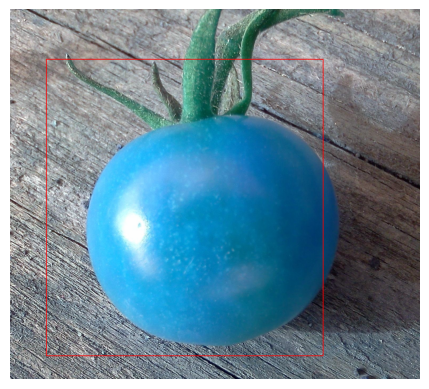

In [6]:
index= 10 #picture to visualize
img_path="/content/drive/MyDrive/SFU_Archive/IAT360/Computer Vision Project/Datasets/Tomato.v1i.yolov8/images/train/Riped-tomato_119_jpeg.rf.719fe2c77324d23fe91225be9c8c2e52.jpg"

#import cv2
image = cv2.imread(img_path, 1)
# Draw rectangle
# cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

#WORKS! obtained these numbers on the original site, they are not in the txt file
# cv2.rectangle(image, (int(697-1085/2), int(643-1237/2)), (int(697+1085/2), int(643+1237/2)), (255, 0, 0), 2)

#This version uses the smallest x coordinate and y xcoordinate from the OBB version
cv2.rectangle(image, (137, 189), (1181, 1307), (255, 0, 0), 2)

# Put label (class_id) near the bbox
# label = train_df["label"][index]
# cv2.putText(image, str(label), (train_df['xmin'][index], train_df['ymin'][index]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
#import glob
#import xml.etree.ElementTree as ET

df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir+"/train" + '/*.xml')):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]